In [82]:
## Common Python modules
import math, sys
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

## EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Libraries for models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## My libraries
# import lazy_turtle.py as lz

In [118]:
## functions (this could then stored in another python file)

def get_outlier_index_iqr(column, threshold=1.5):
    
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = abs(q3-q1)
    
    condition1 = column > q3 + iqr * threshold
    condition2 = column > q1 - iqr * threshold
    
    result = column[condition1 & condition2].index
    return result

def get_pairs(n_rows, n_cols):
    '''Gives you pairs for ploting subploting with an iteration'''
    for i in range(n_rows):
        for j in range(n_cols):
            yield(i,j)
            ## This yielding may look strange 
            ## but is the only way I found to later
            ## pass the code to the axes.


def n_outliers(df, column_name):
    q1 = np.percentile(df[column_name], 25)
    q3 = np.percentile(df[column_name], 75)
    iqr = abs(q3 - q1)
    
    lower = df[column_name][df[column_name] < q1 - 1.5 * iqr]
    higher = df[column_name][df[column_name] > q3 + 1.5 * iqr]
    
    n_lower = len(lower)
    n_higher = len(higher)
    n_total = len(lower) + len(higher)
    
    
    array = np.array([n_lower, round(n_lower/len(df),3) , round(q1 - 1.5 * iqr,2), 
                      n_higher, round(n_higher/len(df),3),  round(q3 + 1.5 * iqr,3),
                      n_total, round(n_total/len(df),3) ,'none']).reshape(3,3)
    
    result = pd.DataFrame(data=array, index=['Lower Higher Total'.split(' ')], columns=['Counts', 'Percentage',
                                                                                        'Threshold'])
    return result

## EDA

In [3]:
path = 'data/creditcardmarketing.xlsx'
df = pd.read_excel(path)
df.columns = [i.lower().replace(' ','_').replace('#', 'n') for i in df.columns]
df = df.drop('customer_number', axis=1)

In [4]:
df.shape

(18000, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_accepted        18000 non-null  object 
 1   reward                18000 non-null  object 
 2   mailer_type           18000 non-null  object 
 3   income_level          18000 non-null  object 
 4   n_bank_accounts_open  18000 non-null  int64  
 5   overdraft_protection  18000 non-null  object 
 6   credit_rating         18000 non-null  object 
 7   n_credit_cards_held   18000 non-null  int64  
 8   n_homes_owned         18000 non-null  int64  
 9   household_size        18000 non-null  int64  
 10  own_your_home         18000 non-null  object 
 11  average_balance       17976 non-null  float64
 12  q1_balance            17976 non-null  float64
 13  q2_balance            17976 non-null  float64
 14  q3_balance            17976 non-null  float64
 15  q4_balance         

In [6]:
df.isna().sum()

offer_accepted           0
reward                   0
mailer_type              0
income_level             0
n_bank_accounts_open     0
overdraft_protection     0
credit_rating            0
n_credit_cards_held      0
n_homes_owned            0
household_size           0
own_your_home            0
average_balance         24
q1_balance              24
q2_balance              24
q3_balance              24
q4_balance              24
dtype: int64

In [7]:
data = df.offer_accepted[df.q1_balance.isna()]
data.value_counts()
## Just check before droping that th distribution is not that off.

No     22
Yes     2
Name: offer_accepted, dtype: int64

In [8]:
balance_nan_drop = df[df.q1_balance.isna()].index
df = df.drop(balance_nan_drop, errors='ignore')
##Just delete all the values were the balances are nan

In [9]:
df.describe()

,n_bank_accounts_open,n_credit_cards_held,n_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600,810.185803
std,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


In [10]:
continuous = df.select_dtypes(include='float')
discrete = df.select_dtypes(include='int')
target = df.offer_accepted
categorical = df.select_dtypes(include='object').drop('offer_accepted', axis=1)

In [11]:
print(len(continuous.columns) + len(discrete.columns) + len(categorical.columns) )

15


In [12]:
df.isna().sum()

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
n_bank_accounts_open    0
overdraft_protection    0
credit_rating           0
n_credit_cards_held     0
n_homes_owned           0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
dtype: int64

There are 24 rows that do not have a balance. There are 2 possibilities: The amount is less than the 

### 1) Check for general outliers

In [123]:
data = df.select_dtypes('float').drop('average_balance',axis=1)

In [130]:
q1_outliers = get_drop_index_iqr(data.q1_balance, threshold=1.2)
q2_outliers = get_drop_index_iqr(data.q2_balance, threshold=1.2)
q3_outliers = get_drop_index_iqr(data.q3_balance, threshold=1.2)
q4_outliers = get_drop_index_iqr(data.q4_balance, threshold=1.2)
index_continuous = np.unique(np.concatenate([q1_outliers,q2_outliers
                                            ,q3_outliers,q4_outliers], 0))

In [131]:
index_continuous

array([ 2296,  2655,  8777,  8887, 10475, 10576, 12633, 12635, 14003,
       15259, 15608])

In [134]:
data = df.select_dtypes('int')

In [142]:
data.n_bank_accounts_open.value_counts() / len(data)

def get_index_value():
    pass

### 2) Train test split

### 3) Check the Value Counts of the target.

In [13]:
target.value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

In [14]:
v_counts = target.value_counts()
v_counts['No'] / v_counts['Yes'] 

16.60626836434868

In [15]:
## What if Just everything is No.
v_counts['No'] / len(target)

0.9432020471740098

It is clear that the target is not well balance. We can see that there is 16.6 times more rejections than accepted offers. This means that if you preddict everything as a 'No' you will actually have more than **94% correct values**. 

### 4) Cheking Continuous Data 

In [16]:
continuous.describe()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,940.515562,910.450656,999.392190,1042.033600,810.185803
std,350.297837,620.077060,457.402268,553.452599,559.001365
min,48.250000,0.000000,0.000000,0.000000,0.000000
25%,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


In [17]:
## This is how it is calculated. First getting the mean of all the values and 
## then apply a describe function.
continuous.iloc[:,1:].mean(axis=1).describe()

count    17976.000000
mean       940.515562
std        350.297837
min         48.250000
25%        787.500000
50%       1007.000000
75%       1153.250000
max       3366.250000
dtype: float64

The first thing we can see that there is a column that is **dependent** on the other 4. This means we can just drop the column. 

In [18]:
average_balance = continuous['average_balance']
continuous = continuous.drop('average_balance',axis=1)

In [19]:
continuous.describe()

,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000
mean,910.450656,999.392190,1042.033600,810.185803
std,620.077060,457.402268,553.452599,559.001365
min,0.000000,0.000000,0.000000,0.000000
25%,392.750000,663.000000,633.000000,363.000000
50%,772.000000,1032.000000,945.500000,703.000000
75%,1521.000000,1342.000000,1463.000000,1212.000000
max,3450.000000,3421.000000,3823.000000,4215.000000


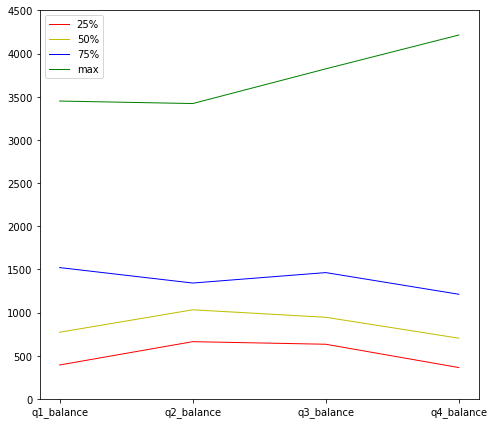

In [20]:
rows = ['25%', '50%', '75%', 'max']
colors = ['r', 'y','b','g']
l_rows = len(rows)

fig = plt.figure(figsize=(7,6))

for i in range(len(rows)):
    column_name = rows[i]
    x = continuous.describe().loc[column_name].index
    y = continuous.describe().loc[column_name].values
    plt.plot(x, y , color=colors[i],linewidth=1, label=rows[i])
    
plt.legend()
plt.ylim(0, 4500)
    
plt.tight_layout()
plt.show()

This is not super precise, but it gives an idea of how behaviour of the different groups from the riches to the poorest. What can be observed is that both **25% and 50%** people start low, gets a better balance throughout the year and then it returns back to low. The **75%** starts high and then slowly descends. And the **100%** keeps going up. This is of course a single value consideration; and the max is probably an outlier. But since the percentiles are calculated by columns and not rows; it could already be giving some insight on the data.

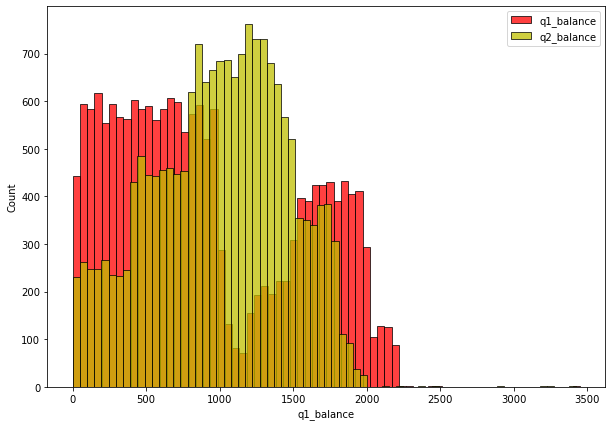

In [21]:
colors = ['r', 'y']
fig, axs = plt.subplots(1,1, figsize=(10,7))
for i in range(2):
    sns.histplot(data=continuous, x=continuous.columns[i],
                 bins=70, ax=axs, color=colors[i], label=continuous.columns[i])

plt.legend()
plt.show()

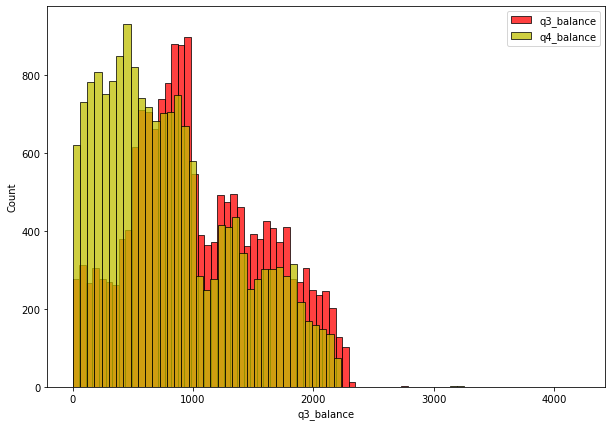

In [22]:
colors = ['r', 'y']
fig, axs = plt.subplots(1,1, figsize=(10,7))
for i in range(2):
    sns.histplot(data=continuous, x=continuous.columns[i+2],
                 bins=70, ax=axs, color=colors[i], label=continuous.columns[i+2])

plt.legend()
plt.show()

This shows a lot of stuff:
1) That there are a lot of outliers, specially in the highest range of the values
<br>2) It looks as if there was some kind of pumping (like a heart)
<br>3) The amount of people with a balance lower to 1000 is highes at the q4 (guess at the end of the year).

Now it is shown the boxplots between each q and the target.

In [23]:
data = pd.concat([continuous,target],axis=1)

In [24]:
data

,q1_balance,q2_balance,q3_balance,q4_balance,offer_accepted
0,1669.0,877.0,1095.0,1002.0,No
1,39.0,106.0,78.0,366.0,No
2,367.0,352.0,145.0,242.0,No
3,1578.0,1760.0,1119.0,419.0,No
4,2140.0,1357.0,982.0,365.0,No
...,...,...,...,...,...
17995,136.0,65.0,71.0,398.0,No
17996,984.0,940.0,943.0,535.0,No
17997,918.0,767.0,1170.0,1494.0,No
17998,626.0,983.0,865.0,1615.0,No


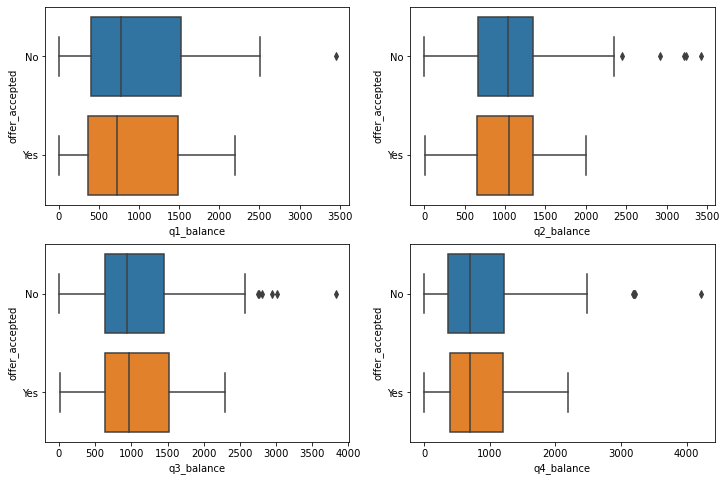

In [25]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
pairs = [i for i in get_pairs(2,2)] # This is needed to make the iteration below work.

for i in range(4):
    axs[pairs[i]].x_lim = (0,4500)
    sns.boxplot(data=data,x=data.columns[i], y='offer_accepted', ax=axs[pairs[i]]) 
plt.show()

As **unexpected** as it may sound, it doesn't seem to be much correlation between the balance someone has and if the accept or not their offer.

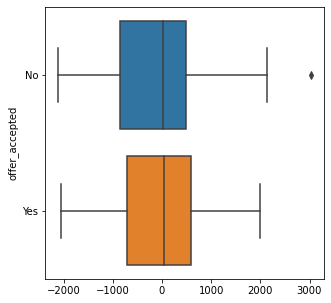

In [26]:
variance_q1_q4 = data['q4_balance'] - data['q1_balance'] ## Because probably what they are watching 
                                                         ## is the way they spend the money.
    
fig = plt.figure(figsize=(5,5))
sns.boxplot(data=data,x=variance_q1_q4, y='offer_accepted') 
plt.show()

## Better, but there is doesn't seem to be significant correlation.

Finally it would be shown what is the relationship between **offer_accepted** and the **outliers**. For this it would be used the average balance.

In [45]:
q1_outliers = get_drop_index_iqr(data.q1_balance, threshold=1.15)
q2_outliers = get_drop_index_iqr(data.q2_balance, threshold=1.15)
q3_outliers = get_drop_index_iqr(data.q3_balance, threshold=1.15)
q4_outliers = get_drop_index_iqr(data.q4_balance, threshold=1.15)
index = np.unique(np.concatenate([q1_outliers,q2_outliers
                                  ,q3_outliers,q4_outliers], 0))

df.offer_accepted[index].value_counts()

No     30
Yes     1
Name: offer_accepted, dtype: int64

This shows that **most outliers** are **being regected**. This may have many reasons that are out of the scope of this analysis.

<function matplotlib.pyplot.show(close=None, block=None)>

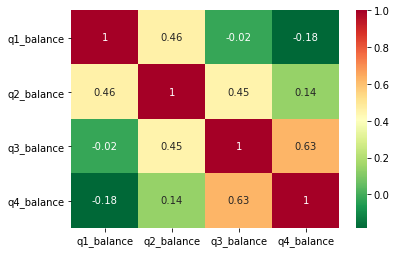

In [55]:
corr = data.corr(method='spearman')
sns.heatmap(corr, cmap='RdYlGn_r',  annot=True)
plt.show

It can be seen that the correlation is not that high. Probably the only thing that is interesting is the negative correlation between balance 1 and balance for.

<AxesSubplot:xlabel='q1_balance', ylabel='q4_balance'>

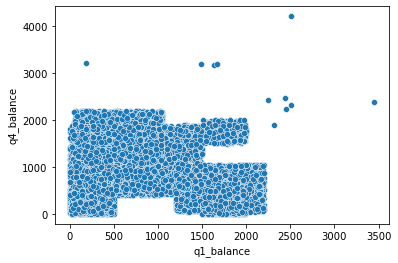

In [59]:
sns.scatterplot(data=data, x='q1_balance',y='q4_balance')

<AxesSubplot:xlabel='q1_balance', ylabel='q3_balance'>

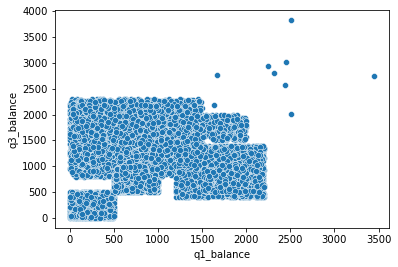

In [60]:
sns.scatterplot(data=data, x='q1_balance',y='q3_balance')

<AxesSubplot:xlabel='q3_balance', ylabel='q4_balance'>

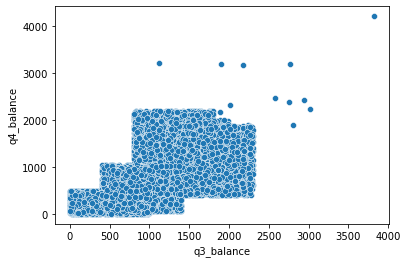

In [61]:
sns.scatterplot(data=data, x='q3_balance',y='q4_balance')

<AxesSubplot:xlabel='q2_balance', ylabel='q3_balance'>

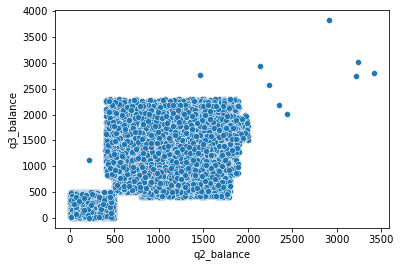

In [62]:
sns.scatterplot(data=data, x='q2_balance',y='q3_balance')

I deffinetely wasn't expecting this sort of **behaviour**. Not even sure what to do with this.

In [ ]:
for i in r

### 5) Checking Discrete Data

In [71]:
for column_name in discrete:
    print(column_name)
    print(discrete[column_name].value_counts())
    print('\n')

n_bank_accounts_open
1    13674
2     4007
3      295
Name: n_bank_accounts_open, dtype: int64


n_credit_cards_held
2    7933
1    6147
3    3381
4     515
Name: n_credit_cards_held, dtype: int64


n_homes_owned
1    14502
2     3289
3      185
Name: n_homes_owned, dtype: int64


household_size
3    5705
4    5532
5    2851
2    2809
1     539
6     538
8       1
9       1
Name: household_size, dtype: int64




Most columns in **discrete** have less than **5 value**. The only one that doesn't follow this rule is **household_size** which **has 9**. Nevertheless, it can be seen that values 8 and 9 only have 1 entry. 

It is clear what the **n_columns** are. But what is the meaning of **household_size** is more **ambiguous** .

In [103]:
map_target = data.offer_accepted.map({'No':0,'Yes':1})
data = pd.concat([discrete, map_target], axis=1)

### 6) Cheking Categorical Data